In [1]:
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import nclcmaps as ncm
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

<>:41: SyntaxWarning: invalid escape sequence '\P'
<>:41: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1606390/715840797.py:41: SyntaxWarning: invalid escape sequence '\P'
  cb.set_label('$\Psi$ [1e9 kg/s]')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


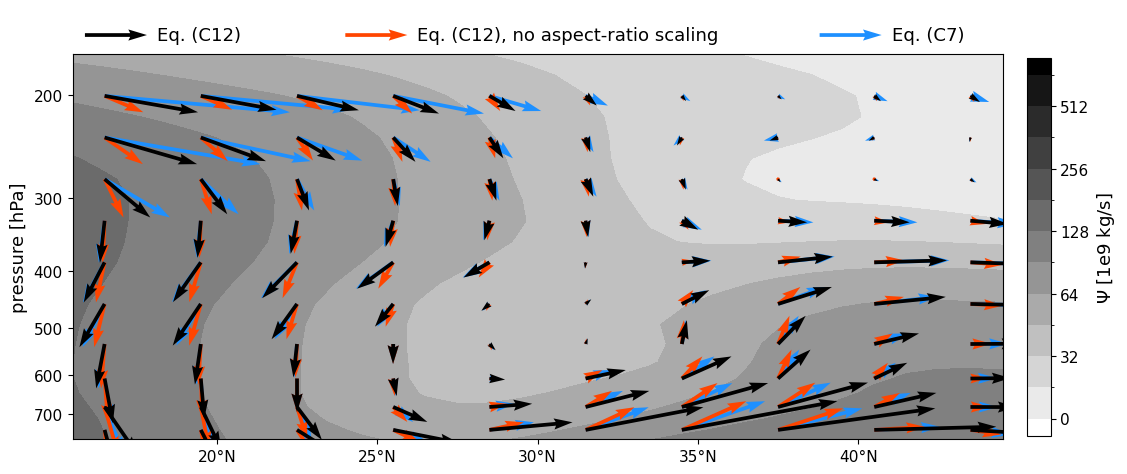

In [21]:
importlib.reload(putil)
importlib.reload(ces)

# ----- get data
tlim   = [date(1992, 12, 1), date(1993, 3, 1)]
#plim = [400, 810]
plim = [165, 790]
latlim = [15, 45]
psitem = putil.get_variable('psitem', freq='monthly', tmin=tlim[0], tmax=tlim[1])
psitem = putil.do_slicing(psitem, pmin=plim[0], pmax=plim[1], latmin=latlim[0], latmax=latlim[1])
psi = psitem['cfmean']

# ----- get coordaintes
LATp, PLEVp = np.meshgrid(psi.lat, psi.plev)

# ----- set contour levels
lev = list(2**np.arange(4.5, 10, 0.5))
psilev = [0] + lev
#psilev = [-l for l in lev[::-1]] + lev

# ----- set vector downsampling frequencies
dslat, dsp = 3, 2

# ----- plotting
log_vectors=False
plot_gradient = False
plot_data_gradn = False
vcolor='k'
pcmap = 'binary'
vscale = 6e12
#vscale=None
vwidth=0.004
cbheight = 0.756 
cbpos    = [0.92, (1-cbheight)/2-0.005, 
            0.02, cbheight] # colorbar position

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
cc = ax.contourf(LATp, PLEVp, (psi.T)/1e9, levels=psilev, cmap=pcmap, extend='both', norm=putil.get_cmap_norm(psilev, 'uneven'), )
cb = fig.colorbar(cc, cax=fig.add_axes(cbpos), orientation='vertical', location='right', extendrect=True)
cb.set_label('$\Psi$ [1e9 kg/s]')
#cb.set_ticklabels(np.array(psilev).astype(int))
#cb.set_ticks(psilev)

putil.format_lat_ticks(ax)
# get non-log scaled vector field
ulin, vlin = putil.streamfunction_gradient_normal(fig, ax, psi, log_vectors=log_vectors, dslat=dslat, dsp=dsp, dsplog=False)

# get log-scaled vector field
putil.format_paxis(ax, ticks=np.arange(plim[1]+10, plim[0]-101, -100))
u, v = putil.streamfunction_gradient_normal(fig, ax, psi, log_vectors=log_vectors, dslat=dslat, dsp=dsp, dsplog=False)

LAT, PLEV = np.meshgrid(u.lat, u.plev)
# plot correct vectors
q = ax.quiver(LAT, PLEV, u.T, v.T, color='k', width=vwidth, scale=vscale, zorder=99)
# plot non-aspect-scaled vectors
fig_width, fig_height    = fig.get_size_inches()
_, _, ax_wsize, ax_hsize = ax.get_position().bounds
dX, dY = fig_width * ax_wsize, fig_height * ax_hsize
qa = ax.quiver(LAT, PLEV, u.T * (dY/dX), v.T, color='orangered', width=vwidth, scale=vscale, zorder=90)
# plot non-log-scaled vectors
ql = ax.quiver(LAT, PLEV, ulin.T, vlin.T, color='dodgerblue', width=vwidth, scale=vscale)

if(plot_gradient):
    qg = ax.quiver(LAT, PLEV, v.T, -u.T, color='w', width=vwidth, scale=vscale)
if(plot_data_gradn):
    u, v = xr.zeros_like(psi), xr.zeros_like(psi)
    u.values, v.values = np.gradient(psi, psi.lat, psi.plev)
    u, v = v, u
    u = putil.downsample_latp(u, dslat, dsp, logp=False)
    v = putil.downsample_latp(v, dslat, dsp, logp=False)
    if(log_vectors):
        u, v = putil.log_quiver(u, v)
    qd = ax.quiver(LAT, PLEV, u.T, v.T, color='white', edgecolor='grey', linewidth = 0.75, width=vwidth, scale=vscale)

ax.set_ylabel('pressure [hPa]')

# ----- make legend
if(vscale is not None): UU = 4e11
else: UU = 1
ax.quiverkey(q, X=0.08, Y=1.05, U=UU,label='Eq. (C12)', labelpos='E', fontproperties={'size':13})
ax.quiverkey(qa, X=0.36, Y=1.05, U=UU,label='Eq. (C12), no aspect-ratio scaling', labelpos='E', fontproperties={'size':13})
ax.quiverkey(ql, X=0.87, Y=1.05, U=UU,label='Eq. (C7)', labelpos='E', fontproperties={'size':13})
ax.legend(bbox_to_anchor=(0.5, 1.1), frameon=False, fancybox=False, edgecolor='k', 
          ncol=4, columnspacing=1, handlelength=1.5, loc='center')

plt.savefig('figs/psi_vectors.png')
plt.show()

In [19]:
12/5

2.4